# Training a commute prediction network, and visualizing learning!  
<ul> latest version available from: https://github.com/miroenev/teach_DL , prerequisites:
* Matplotlib, Numpy, Keras, and <a href="https://github.com/K3D-tools/K3D-jupyter">K3D</a> for realtime training 3D surface visualization
* TensorFlow as the Keras backend for NN graph (queries model weights)

A video walkthrough of this notebook is <a href='https://youtu.be/HgbGJn9yz30'> available on YouTube</a>.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from k3d import K3D

#set default figure size
plt.rcParams['figure.figsize'] = [9.5, 5]

# Define the problem

Lets try to predict commute duration from two observable independent variables: the time of day and the weather conditions.

<img src='figures/commute.png' width='400'/>
<img src='figures/target_distribution.PNG' width='1000'/>
In this toy example we'll first take on the role of the 'traffic gods' and decree that commute duration is defined through a linear mixture of the two independent variables. Later we'll sample from the distribution defined by these variables and generate a training dataset. This sampling procedure will be analogous to keeping a journal of all of our commutes for some [ long ] period of time, where each log entry consists of a set of  
* <b>X</b>: [ time-of-departure, weather-condition ], and the associated  
* <b>Y</b>: [ commute-duration ].

<img src='figures/x_y_mapping.PNG' width='900'/>

Given such a journal [dataset], we'll split it into training (75%) and testing (25%) subsets which we'll use to train and evaulate our model respectively. Specifically, we'll build a neural network model whose weights are initially randomly initialized, but are trained/updated as we stream the training data through (via the backpropagation learning algorithm). Each update will get us closer to having a model that has learned the relationship between X and Y or ([ time-of-departure, weather-condition ] to [ commute-duration] ).

<img src='figures/process.PNG' width='800'/>

During the training process we'll try to visualize the network's behavior by asking it to predict all the entries in our logbook using its current parameters/weights. As the training process unfolds, you should be able to see how the network adapts itself to the target surface/function that we determined for the commute duration.

<img src='figures/training_progress.PNG' width='700'/>

# Determine underlying relationship
We'll start by esablishing (as traffic gods) the relationships between:  
* 1) the time a commute starts (time-of-departure variable) and commute-duration
* 2) the weather when a commute is started (weather-condtion variable) and commute-duration

Note that as data scientists we never get to see this function, but we try to learn it from data.

<IPython.core.display.Javascript object>


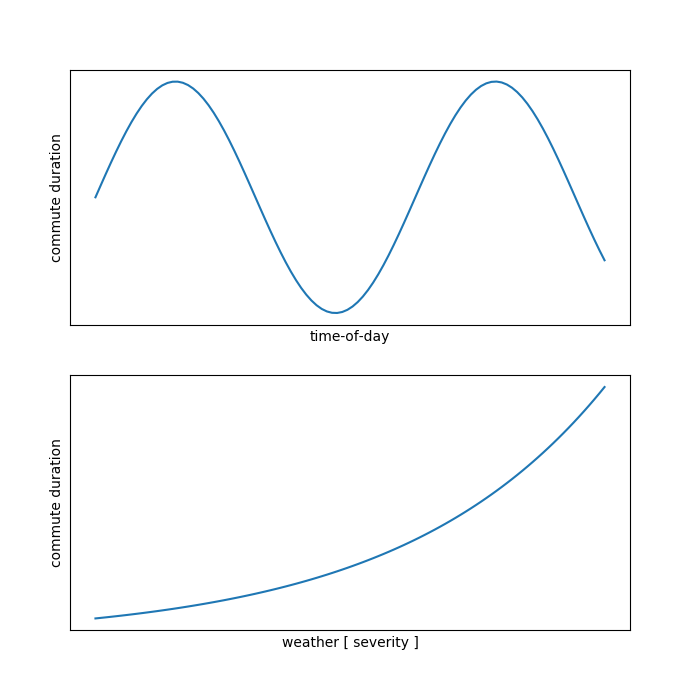

<IPython.core.display.Javascript object>


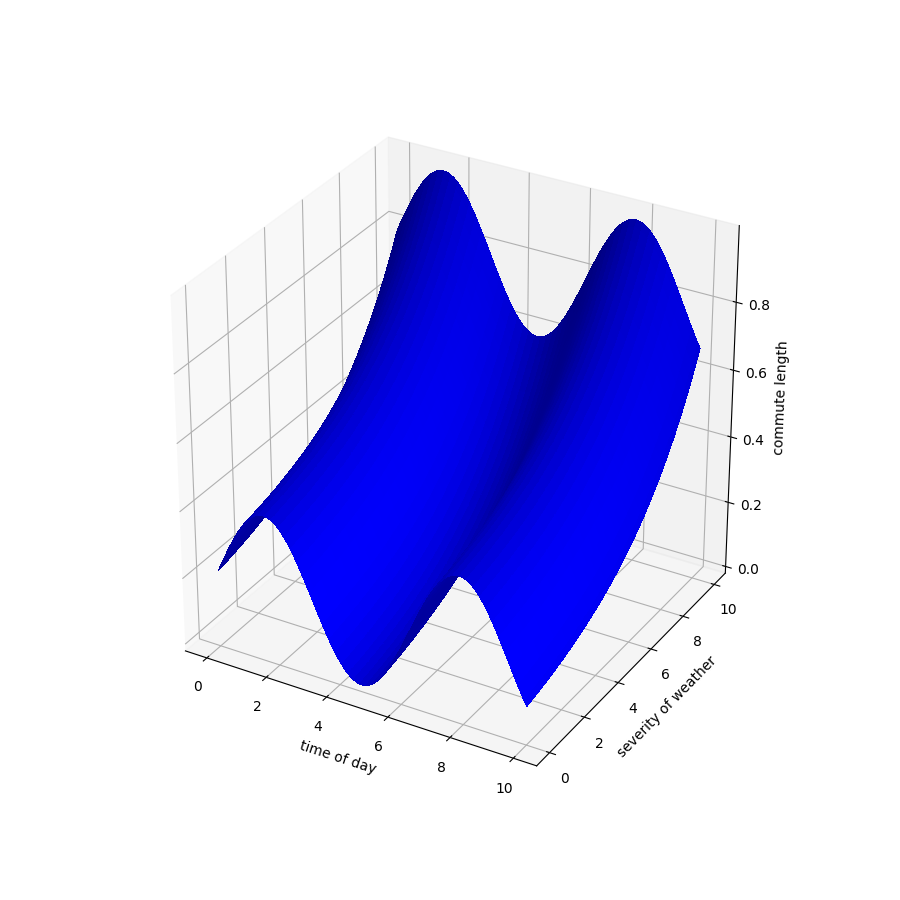

In [3]:
# define data coordinates
xRange = [0,10]; 
yRange = [0,10]; numSteps = 100

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x
    
# define 1D relationships to target
xComponent = np.sin( x ) * 4
yComponent = np.exp( y / 4 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)

# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1, wspace = 0.2 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time-of-day'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('weather [ severity ]'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])

# plot target [dependent] variable
plt.figure( figsize = (9, 9) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()


# Generate  dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [4]:
NSamples = 5000
noiseScaling = 1/8.

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

trainData = np.zeros( ( NSamples, 2 ) )
targetValues = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    trainData[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    trainData[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    targetValues[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]


# Plot dataset samples (red dots) overlayed onto target distribution (blue)

In [5]:
def plot_3D_data (k3dPlot):
    zScaling = 5

    offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                          np.ones((trainData.shape[0], 1)) + 4, 
                          np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

    k3dPlot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ) + offset, color=0xFF0000, point_size = .2, shader = 'flat' )
    k3dPlot += K3D.surface ( z*zScaling, color=0x0055FF, xmin=np.min(trainData[:,0]+offset[::,0]), xmax=np.max(trainData[:,0]+offset[::,0]), ymin=np.min(trainData[:,1]+offset[::,1]), ymax=np.max(trainData[:,1]+offset[::,1]))
    
    return zScaling, offset

plot = K3D()
_, _ = plot_3D_data(plot)
plot.display()

K3D(parameters={'antialias': True, 'height': 512, 'backgroundColor': 16777215})

# Define model structure

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import metrics
import keras

model = Sequential()
model.add( Dense( 20, input_dim = 2 ))
model.add( Dense( 15, activation = 'sigmoid' ))
model.add( Dense( 27, activation = 'sigmoid' ))
model.add( Dense( 1 ))

model.compile(optimizer='adam', loss='mse')

Using TensorFlow backend.


# Visualize network structure

In [7]:
import sys
sys.path.append('utils')
import nnViz
import importlib

<IPython.core.display.Javascript object>


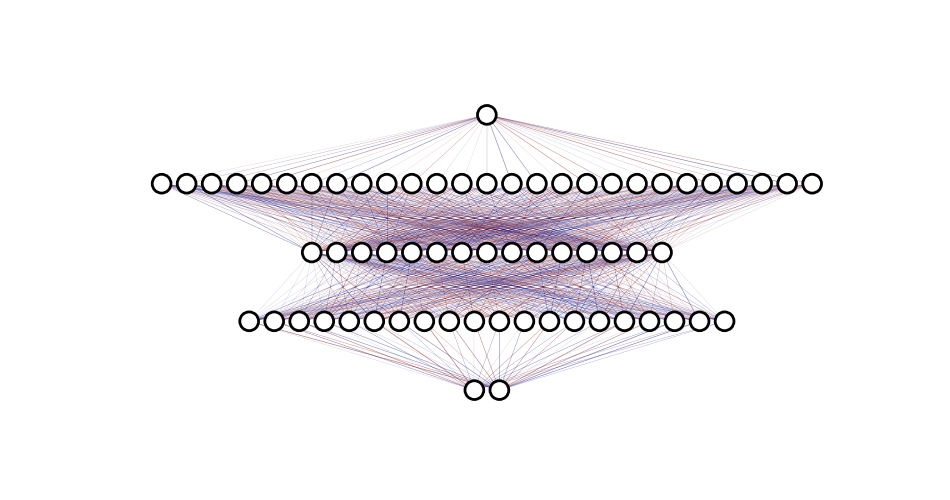

In [8]:
importlib.reload(nnViz)
model.compile(optimizer='adam', loss='mse')
plt.figure()
nnViz.visualize_model(model)
untrainedModelCopy = keras.models.clone_model(model)

Note that the weights all have a similar width/thickness as they are initialized from the same random distribution.

Model structure [loosely] inspired by NVIDIA's new HQ ;]  
http://c.ymcdn.com/sites/aiascv.org/resource/resmgr/meeting_images/2017/March/Nv2.jpeg

# Train Network (and dynamically visualize)

In [9]:
batchSize = 256
numberEpochsToTrain = 200
displayUpdateInterval = 10

In [10]:
currentNN = {}

''' offsets need to keep track of where to plot the latest model predictions '''
xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1))
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0

# placeholders to store loss history
evalLoss = np.empty((numberEpochsToTrain))
evalLoss[:] = np.NaN

# 3D plot
plot = K3D()
zScaling, offset = plot_3D_data(plot)
plot.display()

''' training & plotting loop '''
for iEpoch in range( numberEpochsToTrain ):
    
    # update model parameters
    model.fit ( trainData, targetValues, 
               epochs = 1, 
               batch_size = batchSize,
               verbose = 0, 
               shuffle = True )
     
    # store loss/error history
    evalLoss[iEpoch] = model.evaluate( trainData, targetValues )
    
    # plot logic
    if iEpoch % displayUpdateInterval == 0:
        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        
        currentNN[plotCount] = model.predict( trainData )
        
        print('\n current error: ' + str( evalLoss[plotCount]) )
        plot += K3D.points ( np.hstack( ( trainData, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        plot += K3D.text2d ( str( round(evalLoss[plotCount], 4 )), comboOffset + offset + (0, 0, 3), color=0xff00ff, size=.5, reference_point='rb')
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

K3D(parameters={'antialias': True, 'height': 512, 'backgroundColor': 16777215})

5000/5000 [==============================] - 0s 40us/step

 current error: 0.0527928121567
5000/5000 [==============================] - 0s 44us/step

 current error: 0.0383650614262
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0321701825947
5000/5000 [==============================] - 0s 44us/step

 current error: 0.0298486085892
5000/5000 [==============================] - 0s 36us/step

 current error: 0.0286731278241
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0276486030459
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0267984956563
5000/5000 [==============================] - 0s 41us/step

 current error: 0.0261402160704
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0255998018622
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0250560420662
5000/5000 [==============================] - 0s 38us/step

 current error: 0.0246757340461

5000/5000 [==============================] - 0s 39us/step

 current error: 0.0234450914741
5000/5000 [==============================] - 0s 39us/step

 current error: 0.0231752001375
5000/5000 [==============================] - 0s 38us/step

 current error: 0.0229759355813
5000/5000 [==============================] - 0s 43us/step

 current error: 0.022728836751
5000/5000 [==============================] - 0s 37us/step

 current error: 0.0226546229482
5000/5000 [==============================] - 0s 38us/step

 current error: 0.0222863682151
5000/5000 [==============================] - 0s 35us/step


# Plot learning curve

<IPython.core.display.Javascript object>


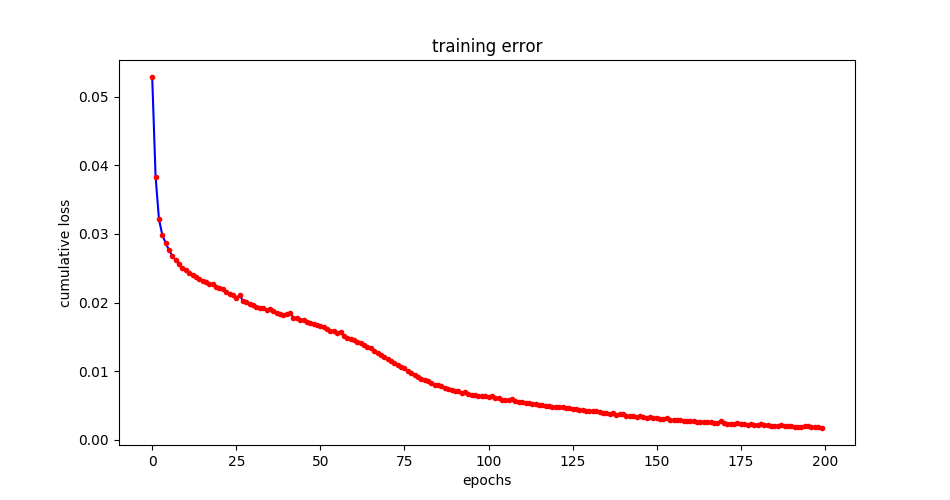

Text(0,0.5,'cumulative loss')

In [11]:
plt.figure()
plt.plot(evalLoss[:], 'b')
plt.plot(evalLoss[:], 'or', markersize=3)
plt.title('training error')
plt.xlabel('epochs')
plt.ylabel('cumulative loss')

# Visualize network predictions <font color=FF0000>before</font> any training

In [12]:
plot = K3D()
plot += K3D.points ( np.hstack( ( trainData, currentNN[0]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

K3D(parameters={'antialias': True, 'height': 512, 'backgroundColor': 16777215})

# Visualize network predictions <font color=FF0000>midway</font> through training

In [13]:
plot = K3D()

plot += K3D.points ( np.hstack( ( trainData, currentNN[int(plotCount/2)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x555555, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

K3D(parameters={'antialias': True, 'height': 512, 'backgroundColor': 16777215})

# Visualize network predictions at <font color=FF0000>end</font> of training

In [14]:
plot = K3D()
plot += K3D.points ( np.hstack( ( trainData, currentNN[plotCount-1]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x555555, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

K3D(parameters={'antialias': True, 'height': 512, 'backgroundColor': 16777215})

# Visualize weights before and after training

<IPython.core.display.Javascript object>


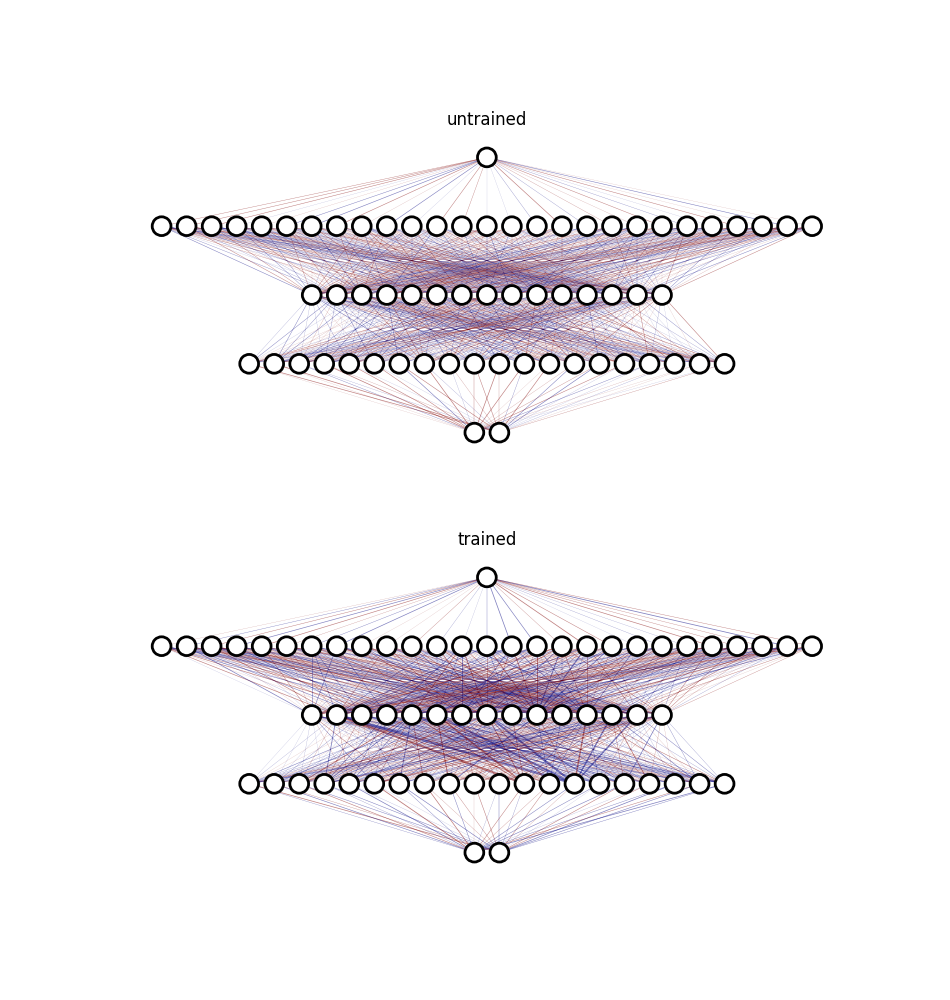

In [15]:
importlib.reload(nnViz)

plt.figure(figsize=(9.5,10))

plt.subplot(2,1,1)
nnViz.visualize_model(untrainedModelCopy)
plt.title('untrained');

plt.subplot(2,1,2)
plt.title('trained');
nnViz.visualize_model(model)

In [16]:
print('thanks!')

thanks!
